# DS 7331 - Machine Learning - Course Project
Team: Allison Roderick, Jayson Barker, Sandesh Ojha, Brandon Croom

Lab Number: 3

## Business Understanding - 10pts

Traffic accidents impact many of us in our daily lives. From being delayed due to an accident to being in an accident ourselves, anytime we are travelling there is a concern that a traffic accident could impact us. The US Accidents dataset is a country wide dataset covering 49 states within the United States. The data has been collected from several data sources which broadcast traffic accident related information. The dataset spans the time period of Feburary 2016 through December 2019. The data was sourced from the Kaggle website (https://www.kaggle.com/sobhanmoosavi/us-accidents).

This data could be leveraged for multiple purposes:

- Alerting drivers to when an accident may occur
- Providing insurance companies information on accident fequencies
- Assisting government agencies in future traffic pattern design and planning

A good prediction algorithm for this data would establish a relationship between the factors in this data file, such as weather, time of day, location, and the severity of an accidents occurrence. We would know if the algorithm was useful if it could successfully predict how severe an accident would be based on those variables. In knowing the severity, we could recommend to civic institutions how, where, and when to allocate the most resources for accidents. 

## Data Understanding - 10pts

Setup initial requirements for the data analysis prior to EDA. This is for cleanliness of the code base and consistency of outputs.

In [1]:
# Import libraries for data analysis
import numpy as np 
import pandas as pd 
import pandas_profiling as pp
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib as pathlib

from sklearn.model_selection import train_test_split
from IPython.display import display,HTML
from sklearn import ensemble

#The packages below will need to be installed for use.
# sorted_months_weekdays allows for easier manipulation of date fields
from sorted_months_weekdays import Month_Sorted_Month, Weekday_Sorted_Week
import swifter

# show all columns
pd.set_option('display.max_columns', None) 

#Set the seaborn plotting style
sns.set(style="darkgrid")

#set variables for font sizes for plots. This will allow them to be consistent within the notebook
titleFont = 25
axisFont = 15
labelFont = 15

Define helper functions for data analysis

In [2]:
#build out helper functions
def getMedianTemp(row):
    month = row['Start_Month']
    
    try:
        result = medianTempByMonth[month]
    except:
        result = 0
    finally:    
        return result

def getMedianPrecip(row):
    month = row['Start_Month']
    state = row['State']
    
    try:
        result = medianPrecipByMonth[month]
    except:
        result = 0
    finally:
        return result

def getMedianPressure(row):
    month = row['Start_Month']
    
    try:
        result = medianPressureByMonth[month]
    except:
        result = 0
    finally:
        return result

def getMedianWindChill(row):
    month = row['Start_Month']
    
    try:
        result = medianWindChillByMonth[month]
    except:
        result = 0
    finally:
        return result

def getMedianVis(row):
    month = row['Start_Month']
    
    try:
        result = medianVisByMonth[month]
    except:
        result = 0
    finally:
        return result

def getMedianWindSpeed(row):
    month = row['Start_Month']
    
    try:
        result = medianWindSpeedByMonth[month]
    except:
        result = 0
    finally:
        return result

def getMedianHumidity(row):
    month = row['Start_Month']
    
    try:
        result = medianHumidityByMonth[month]
    except:
        result = 0
    finally:
        return result

def checkMissingValues(df,percent):
    missing_df = df.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['columns_name','missing_count']
    missing_df['missing_ratio'] = missing_df['missing_count'] /df.shape[0]
    return missing_df.loc[missing_df['missing_ratio']>percent]

Read in the datafile for analysis and perform a quick test to make sure we read the data in correctly

In [3]:
#read in the data file
data_file = 'us-accidents.zip'
weather_dic = 'WeatherDict.csv'

#BC's filepaths
filepath_BC = '/home/jbcroom/'
filepath_BC2 = 'C:/RAI/'

#AR's filepaths
filepath_AR = ''

#HB's filepaths
filepath_JB = ''

#SO's filepaths
filepath_SO = ''

#Get the information for the data file
datafile_pathBC = pathlib.Path(filepath_BC + weather_dic)
datafile_pathBC2 = pathlib.Path(filepath_BC2 + weather_dic)
datafile_pathAR = pathlib.Path(filepath_AR + weather_dic)
datafile_pathJB = pathlib.Path(filepath_JB + weather_dic)
datafile_pathSO = pathlib.Path(filepath_SO + weather_dic)

#Check to where the file exists and set the filepath to load the data. 
if (datafile_pathBC.exists):
    weatherDic = filepath_BC + weather_dic
elif (datafile_pathBC2.exists):
    weatherDic = filepath_BC2 + weather_dic
elif (datafile_pathAR.exists):
    weatherDic = filepath_AR + weather_dic
elif (datafile_pathJB.exists):
    weatherDic = filepath_JB + weather_dic
elif (datafile_pathSO.exists):
    weatherDic = filepath_SO + weather_dic

#Get the information for the data file
datafile_pathBC = pathlib.Path(filepath_BC + data_file)
datafile_pathBC2 = pathlib.Path(filepath_BC2 + data_file)
datafile_pathAR = pathlib.Path(filepath_AR + data_file)
datafile_pathJB = pathlib.Path(filepath_JB + data_file)
datafile_pathSO = pathlib.Path(filepath_SO + data_file)

#Check to where the file exists and set the filepath to load the data. 
if (datafile_pathBC.exists):
    finalpath = filepath_BC + data_file
elif (datafile_pathBC2.exists):
    finalpath = filepath_BC2 + data_file
elif (datafile_pathAR.exists):
    finalpath = filepath_AR + data_file
elif (datafile_pathJB.exists):
    finalpath = filepath_JB + data_file
elif (datafile_pathSO.exists):
    finalpath = filepath_SO + data_file

#load the datafile
df = pd.read_csv(finalpath)
df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,NaN,State Route 32,R,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,I-75 S,R,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,NaN,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


The code below provides a quick check on the shape of the data which will provide the number of rows in the data and number of data columns.

In [4]:
df.shape

(2974335, 49)

From the output above there are 2,974,335 rows of data with 49 initial data columns. 

To gain additional insight into the data, the data types of each column need to be understood. This allows for an understanding of whether the data is categorical or continuous. The code below will provide a summary count of all of the data type values as well as the individual listing of data types for each column

In [5]:
df.dtypes.value_counts()

object     21
float64    14
bool       13
int64       1
dtype: int64

In [6]:
df.dtypes

ID                        object
Source                    object
TMC                      float64
Severity                   int64
Start_Time                object
End_Time                  object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description               object
Number                   float64
Street                    object
Side                      object
City                      object
County                    object
State                     object
Zipcode                   object
Country                   object
Timezone                  object
Airport_Code              object
Weather_Timestamp         object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi)           float64
Wind_Direction            object
Wind_Speed(mph)          float64
Precipitat

Assessing and addressing the quality of the data set is critical to ensuring a successful execution of further analysis. In this section data quality will be addressed by looking for and correcting: duplicate data and missing data.

Initially, we check the dataset for any data duplication. This will verify whether the data counts are truly as large as initially seen upon data loading.

In [7]:
#get the shape of the dataframe (number of rows, number of columns)
initShape = df.shape

#remove duplicates from the dataframe
df = df[~df.duplicated()]

#get the shape of the deduplicated dataframe (number of rows, number of columns)
dedupShape = df.shape

#Print out the shape of the initial dataframe, the deduplicated dataframe and 
#determine if there is any duplication in the data
print("Initial Shape: ", initShape)
print("Deduplication Shape: ", dedupShape)


if (initShape == dedupShape):
    print("No Duplicate Data Found")
else:
    print("Duplicate Data Found and removed")

Initial Shape:  (2974335, 49)
Deduplication Shape:  (2974335, 49)
No Duplicate Data Found


As seen from the code execution above there is no duplication found within the data set.

From the initial analysis shown in Table 1 (above) the amount of missing data in the data set is relatively minimal. This section will provide additional verification and address the quality issues.

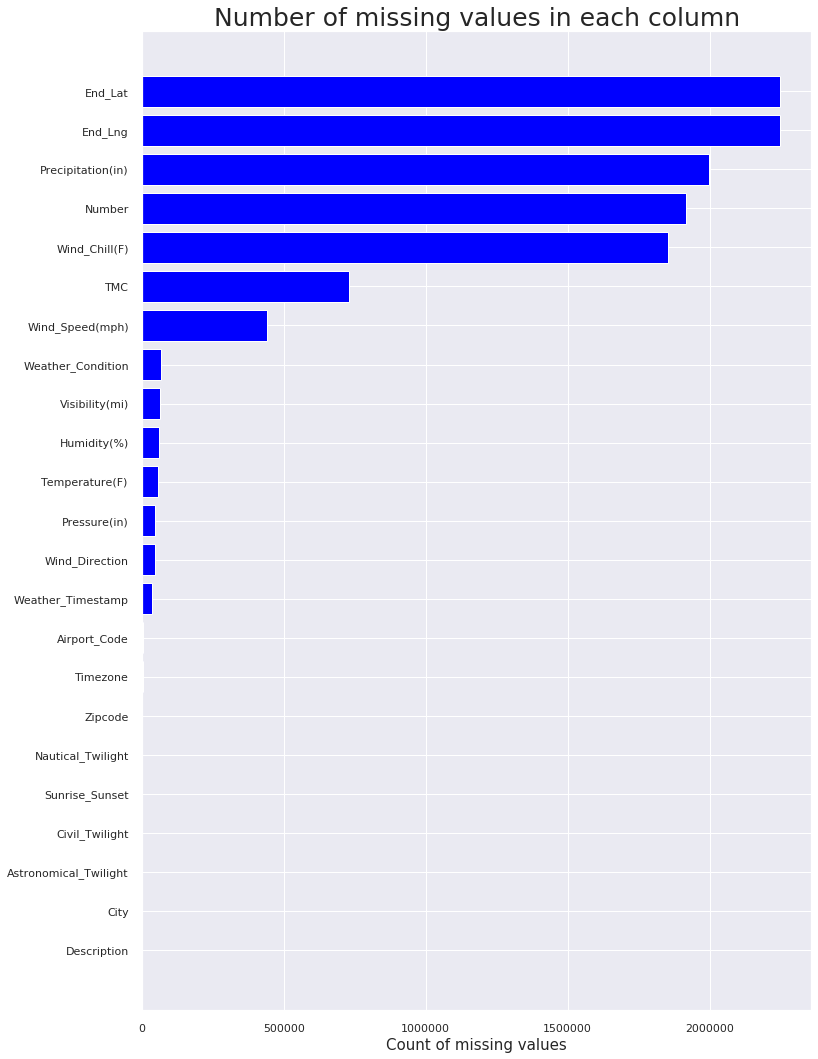

In [8]:
# Look for missing data and plot values for visuals
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name','missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
fig,ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind,missing_df.missing_count.values,color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values",fontsize=axisFont)
ax.set_title("Number of missing values in each column",fontsize=titleFont)
plt.show()

The visualization above confirms the information in Table 1. The columns: End_Lat, End_Long, Precipitation, Number, Wind Chill, TMC and Wind Speed all contain a large amount of missing data. 

Digging a bit deeper into this missing data will provide an indication and additional verification of how much data is missing. Build out a table listing the missing values.

In [9]:
#Get table listing of missing values
checkMissingValues(df,0.00)

,columns_name,missing_count,missing_ratio
2,TMC,728071,2.447845e-01
8,End_Lat,2246264,7.552155e-01
9,End_Lng,2246264,7.552155e-01
11,Description,1,3.362096e-07
12,Number,1917605,6.447172e-01
15,City,83,2.790540e-05
18,Zipcode,880,2.958645e-04
20,Timezone,3163,1.063431e-03
21,Airport_Code,5691,1.913369e-03
22,Weather_Timestamp,36705,1.234057e-02


The additional confirmation of these missing data items continues to match all the previous analysis. Given the high percentage of missing data in many of these fields it seems more beneficial to remove them from the analysis than to impute the data. The following actions will be taken on the data columns:

- End_Lat - remove due to high percentage of data missing
- End_Log - remove due to high percentage of data missing
- Number - remove due to high percentage of data missing
- TMC - remove due to high percententage of data missing
- Wind_Chill(F) - keep and inpute the required values
- Precipitation(in) - keep and inpute the required values


Begin building a list of the columns to be removed from the data set.

In [10]:
#build a list of columns to remove based on the missing ratio data above. Keep Wind_Chill and Precipitation. 
#Use a 15% threshold here
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['columns_name','missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] /df.shape[0]
missing = missing_df.loc[missing_df['missing_ratio']>0.15]
removelist = missing['columns_name'].tolist()

#List columns to keep
keep_columns = {'Wind_Chill(F)', 'Precipitation(in)'} 
  
removelist = [ele for ele in removelist if ele not in keep_columns] 
removelist

['TMC', 'End_Lat', 'End_Lng', 'Number']

Now that columns have been analyzed for missing values, let's move on to evaluate other columns that may need to be removed or cleaned up due lack of uniqueness of data or data inconsistencies. Continue to build the list of fields to be removed and correct data as we progress through the analysis

In [11]:
df.nunique()

ID                       2974335
Source                         3
TMC                           21
Severity                       4
Start_Time               2743101
End_Time                 2761499
Start_Lat                1002359
Start_Lng                 985099
End_Lat                   298605
End_Lng                   302906
Distance(mi)               12847
Description              1597506
Number                     37398
Street                    160715
Side                           3
City                       11685
County                      1713
State                         49
Zipcode                   377152
Country                        1
Timezone                       4
Airport_Code                1995
Weather_Timestamp         470781
Temperature(F)               827
Wind_Chill(F)                971
Humidity(%)                  100
Pressure(in)                 994
Visibility(mi)                81
Wind_Direction                24
Wind_Speed(mph)              147
Precipitat

From the information above the following fields need further investigation to determine removal or cleanup:
- Wind_Direction
- Source
- Description
- ZipCode
- Weather Timestamp

We'll also use this an an opportunity to clean up the multiple captures of sunrise/sunset features. We'll pair this down to just the sunrise/sunset feature and add the others to out list of columns to remove.

In [12]:
#Add items to the remove list
#Look at the sources
print(df.Source.unique())

#There are only three sources and they more than likely have no bearing on analysis. Add them to the remove list
removelist.append('Source')

#The description field is largely text descriptors of the accidents. 
removelist.append('Description')

#The weather timestamp is just timing for when the weather report was used.
removelist.append('Weather_Timestamp')

#The street field is another field for removal. Focus is more at city/county/state level
removelist.append('Street')

#There are multiple versions of the different sunrise/sunset features. Filter down to just sunrise/sunset for analysis
removelist.append('Civil_Twilight')
removelist.append('Nautical_Twilight')
removelist.append('Astronomical_Twilight')

#verify fields were added to the list
removelist

['MapQuest' 'MapQuest-Bing' 'Bing']


['TMC',
 'End_Lat',
 'End_Lng',
 'Number',
 'Source',
 'Description',
 'Weather_Timestamp',
 'Street',
 'Civil_Twilight',
 'Nautical_Twilight',
 'Astronomical_Twilight']

In [13]:
#clean up inconsistencies in the data. 
#Make the wind direction values consistent. Look at the values to determine uniqueness.
print(df.Wind_Direction.unique())
df.Wind_Direction = df.Wind_Direction.replace('South','S')
df.Wind_Direction = df.Wind_Direction.replace('North','N')
df.Wind_Direction = df.Wind_Direction.replace('West','W')
df.Wind_Direction = df.Wind_Direction.replace('East','E')
df.Wind_Direction = df.Wind_Direction.replace('Variable','VAR')
(print(df.Wind_Direction.unique()))

#Zipcodes are a mix of 5-digit and Zip+4 values. Go ahead and make them all 5-digit zipcodes to consistency
df.Zipcode = df.Zipcode.str.slice(0,5,1)

['Calm' 'SW' 'SSW' 'WSW' 'WNW' 'NW' 'West' 'NNW' 'NNE' 'South' 'North'
 'Variable' 'SE' 'SSE' 'ESE' 'East' 'NE' 'ENE' 'E' 'W' nan 'S' 'VAR'
 'CALM' 'N']
['Calm' 'SW' 'SSW' 'WSW' 'WNW' 'NW' 'W' 'NNW' 'NNE' 'S' 'N' 'VAR' 'SE'
 'SSE' 'ESE' 'E' 'NE' 'ENE' nan 'CALM']


Wind Direction and Zipcode values are now constent. We will still need to address the missing values, but will come back to those as we make more decisions

For better data understanding we also want to rename some columns that may be confusing specifically:

- Amenity - this will be renamed PointOfInterest to better reflect what it is
- Give_Way - this will be renamed to Yield

In [14]:
#Convert column names as described above and verify
df.rename(columns={'Amenity':'PointOfInterest'},inplace=True)
df.rename(columns={'Give_Way':'Yield'},inplace=True)
df.dtypes

ID                        object
Source                    object
TMC                      float64
Severity                   int64
Start_Time                object
End_Time                  object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description               object
Number                   float64
Street                    object
Side                      object
City                      object
County                    object
State                     object
Zipcode                   object
Country                   object
Timezone                  object
Airport_Code              object
Weather_Timestamp         object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi)           float64
Wind_Direction            object
Wind_Speed(mph)          float64
Precipitat

Now that the data is relatively clean, let's add a additional columns to help with further data visualizations. Perform the follwing tasks:

- break the accident start time into component parts of year, month, day, hour, minute, second
- break the accident end time into component parts of year, month, day, hous, minute, second
- create a new feature for accident duration

As part of the feature build out ensure we that we don't create any invalid values and clean up times when we do have invaid values

In [15]:
#Add additional features for breaking apart time for EDA
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday for Start values
df['Start_Year']=df['Start_Time'].dt.year
df['Start_Month']=df['Start_Time'].dt.strftime('%b')
df['Start_Day']=df['Start_Time'].dt.day
df['Start_Hour']=df['Start_Time'].dt.hour
df['Start_Weekday']=df['Start_Time'].dt.strftime('%a')
df['Start_Date']=df['Start_Time'].dt.date

# Extract year, month, day, hour and weekday for End values
df['End_Year']=df['End_Time'].dt.year
df['End_Month']=df['End_Time'].dt.strftime('%b')
df['End_Day']=df['End_Time'].dt.day
df['End_Hour']=df['End_Time'].dt.hour
df['End_Weekday']=df['End_Time'].dt.strftime('%a')
df['End_Date']=df['Start_Time'].dt.date

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
df['Time_Duration(min)']=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))

In [16]:
#Check for invalid time durations
df['Time_Duration(min)'][df['Time_Duration(min)']<=0]

69719      -0.0
69720      -0.0
69721      -0.0
69722      -1.0
69723      -1.0
309387    -30.0
309388    -30.0
628436    -12.0
628472    -31.0
628489     -0.0
628923    -14.0
628942     -0.0
628943    -30.0
1265261   -30.0
1265262   -31.0
2002026   -30.0
2002111   -30.0
2002112   -31.0
2565229   -34.0
2565705    -7.0
2565708    -7.0
2693474   -31.0
Name: Time_Duration(min), dtype: float64

In [17]:
# Drop the rows with td<0

neg_outliers=df['Time_Duration(min)']<=0

# Set outliers to NAN
df[neg_outliers] = np.nan

# Drop rows with negative time durations
df.dropna(subset=['Time_Duration(min)'],axis=0,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2974313 entries, 0 to 2974334
Data columns (total 62 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   TMC                    float64       
 3   Severity               float64       
 4   Start_Time             datetime64[ns]
 5   End_Time               datetime64[ns]
 6   Start_Lat              float64       
 7   Start_Lng              float64       
 8   End_Lat                float64       
 9   End_Lng                float64       
 10  Distance(mi)           float64       
 11  Description            object        
 12  Number                 float64       
 13  Street                 object        
 14  Side                   object        
 15  City                   object        
 16  County                 object        
 17  State                  object        
 18  Zipcode               

In [18]:
# Remove outliers for Time_Duration(min): n * standard_deviation (n=3), backfill with median
n=3

median = df['Time_Duration(min)'].median()
std = df['Time_Duration(min)'].std()
outliers = (df['Time_Duration(min)'] - median).abs() > std*n

# Set outliers to NAN
df[outliers] = np.nan

# Fill NAN with median
df['Time_Duration(min)'].fillna(median, inplace=True)

In reviewing the Weather Condition column there seems to be a lot of different categorization for the same types of weather conditions. For example, Thunderstorms are listed as "Thunderstorms", "T-Storm", "Heavy T-Storm", etc. To make the analysis easier we've build out a dictionary that collapses these weather condition into common values for easier analysis

In [19]:
df['Weather_Condition_Collapsed'] = df['Weather_Condition']
print(df['Weather_Condition_Collapsed'].unique())

WeatherDic = {}

with open(weatherDic) as f:
    for line in f:
        (key, val) = line.split(",")
        WeatherDic[key] = val.strip()

print (WeatherDic)

df.Weather_Condition_Collapsed.replace(WeatherDic,inplace=True)

#add the original weather condition value to the list of columns to remove.
removelist.append('Weather_Condition')

(print(df['Weather_Condition_Collapsed'].unique()))

['Light Rain' 'Overcast' 'Mostly Cloudy' 'Rain' 'Light Snow' 'Haze'
 'Scattered Clouds' 'Partly Cloudy' 'Clear' 'Snow'
 'Light Freezing Drizzle' 'Light Drizzle' 'Fog' 'Shallow Fog' 'Heavy Rain'
 'Light Freezing Rain' 'Cloudy' 'Drizzle' nan 'Light Rain Showers' 'Mist'
 'Smoke' 'Patches of Fog' 'Light Freezing Fog' 'Light Haze'
 'Light Thunderstorms and Rain' 'Thunderstorms and Rain' 'Fair'
 'Volcanic Ash' 'Blowing Sand' 'Blowing Dust / Windy' 'Widespread Dust'
 'Fair / Windy' 'Rain Showers' 'Mostly Cloudy / Windy'
 'Light Rain / Windy' 'Hail' 'Heavy Drizzle' 'Showers in the Vicinity'
 'Thunderstorm' 'Light Rain Shower' 'Light Rain with Thunder'
 'Partly Cloudy / Windy' 'Thunder in the Vicinity' 'T-Storm'
 'Heavy Thunderstorms and Rain' 'Thunder' 'Heavy T-Storm' 'Funnel Cloud'
 'Heavy T-Storm / Windy' 'Blowing Snow' 'Light Thunderstorms and Snow'
 'Heavy Snow' 'Low Drifting Snow' 'Light Ice Pellets' 'Ice Pellets'
 'Squalls' 'N/A Precipitation' 'Cloudy / Windy' 'Light Fog' 'Sand'
 'Snow G

We've also selected the state of Texas as our primary state of interest for this analysis. We chose a single state because we felt that traffic accidents and patterns can vary heavily from state to state; some states have longer streches of rural driving vs others that may have more city driving. As a result, the potential features related to accident severity and backups created from those accidents could vary widely. We chose Texas to focus our analysis on because we felt it has a good mix of rural and urban driving conditions. 

With this in mind filter the data set down to just TX data. Also, now that we've filtered down to one state, we can add the state column to our list of columns to remove.

In [20]:
df = df[df['State'] == 'TX']
removelist.append('State')
df.shape

(298058, 63)

As noted above some fields have missing values. Those fields are:

- Wind Chill
- Precipitation
- Visibility
- Humidity
- Temperature
- Pressure
- Wind_Speed

Since this is weather information that is missing we'll use the median values for imputation of missing values. To help with making this imputation as accurate as possible we'll need to look at the state and month. We've already filtered by state so we won't need to take this into account. We will need to manage the values by month. This will allow for to to get monthly averages that should be more accurate.

In [22]:
medianTempByMonth = df.groupby(['Start_Month'])['Temperature(F)'].median()
medianPrecipByMonth  = df.groupby(['Start_Month'])['Precipitation(in)'].median()
medianPressureByMonth  = df.groupby(['Start_Month'])['Pressure(in)'].median()
medianWindChillByMonth  = df.groupby(['Start_Month'])['Wind_Chill(F)'].median() 
medianVisByMonth  = df.groupby(['Start_Month'])['Visibility(mi)'].median()
medianWindSpeedByMonth  = df.groupby(['Start_Month'])['Wind_Speed(mph)'].median()
medianHumidityByMonth  = df.groupby(['Start_Month'])['Humidity(%)'].median()

df.loc[pd.isnull(df['Temperature(F)']),'Temperature(F)'] = df.swifter.apply(getMedianTemp, axis=1)
df.loc[pd.isnull(df['Precipitation(in)']),'Precipitation(in)'] = df.swifter.apply(getMedianPrecip,axis=1)
df.loc[pd.isnull(df['Pressure(in)']),'Pressure(in)'] = df.apply(getMedianPressure,axis=1)
df.loc[pd.isnull(df['Wind_Chill(F)']),'Wind_Chill(F)'] = df.apply(getMedianWindChill,axis=1)
df.loc[pd.isnull(df['Visibility(mi)']),'Visibility(mi)'] = df.apply(getMedianVis,axis=1)
df.loc[pd.isnull(df['Wind_Speed(mph)']),'Wind_Speed(mph)'] = df.swifter.apply(getMedianWindSpeed,axis=1)
df.loc[pd.isnull(df['Humidity(%)']),'Humidity(%)'] = df.swifter.apply(getMedianHumidity,axis=1)
  

/home/jbcroom/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Double check for any additional missing items that we need to address.

In [23]:
#Get table listing of missing values
checkMissingValues(df,0.00)

,columns_name,missing_count,missing_ratio
2,TMC,39697,0.133185
8,End_Lat,258361,0.866815
9,End_Lng,258361,0.866815
11,Description,1,0.000003
12,Number,175967,0.590378
20,Timezone,25,0.000084
21,Airport_Code,25,0.000084
22,Weather_Timestamp,4791,0.016074
28,Wind_Direction,5117,0.017168
31,Weather_Condition,6763,0.022690


Now that all fields have been corrected and columns also identified for removal, proceed with removal of the data fields and verify the shape to show they were dropped

In [24]:
#drop the columns identified with limited data
df.drop(removelist,1,inplace=True)

#check the data shape
print(df.shape)
print(df.dtypes)

(298058, 50)
ID                                     object
Severity                              float64
Start_Time                     datetime64[ns]
End_Time                       datetime64[ns]
Start_Lat                             float64
Start_Lng                             float64
Distance(mi)                          float64
Side                                   object
City                                   object
County                                 object
Zipcode                                object
Country                                object
Timezone                               object
Airport_Code                           object
Temperature(F)                        float64
Wind_Chill(F)                         float64
Humidity(%)                           float64
Pressure(in)                          float64
Visibility(mi)                        float64
Wind_Direction                         object
Wind_Speed(mph)                       float64
Precipitation(in)    

Check to see what other values are missing. Go ahead and clean these up. We'll then verify our shape. 

In [25]:
#Get table listing of missing values
checkMissingValues(df,0.00)

,columns_name,missing_count,missing_ratio
12,Timezone,25,0.000084
13,Airport_Code,25,0.000084
19,Wind_Direction,5117,0.017168
49,Weather_Condition_Collapsed,6763,0.022690


In [26]:
df.dropna(inplace=True)

In [27]:
#Get table listing of missing values
checkMissingValues(df,0.00)

,columns_name,missing_count,missing_ratio


In [28]:
df.shape

(290989, 50)

Now that all data is cleaned up, lets move forward with building out the necessary features for analysis and one-hot encoding the categorical variables.

In [29]:
#Take an initial pass at the features we want to run through logistic regression
featuresList = ['Severity','Start_Lat','Start_Lng','Distance(mi)','Side','Temperature(F)','Wind_Chill(F)',
                'Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)',
                'PointOfInterest','Bump','Crossing','Yield','Junction','No_Exit','Railway',
                'Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset',
                'Start_Month','Start_Hour','Start_Weekday','Time_Duration(min)',
                'Timezone','Start_Time','Weather_Condition_Collapsed']


#filter down the dataframe to just the features needed. We'll create a new dataframe just to be safe
df2 = df[featuresList]

In [30]:
# transform categories into dummy numerics
cols_to_transform = ['Side','Sunrise_Sunset','Start_Weekday','Start_Month','Weather_Condition_Collapsed']

df2 = pd.get_dummies(df2, columns = cols_to_transform)

#check to make sure everything transformed
df2.dtypes

Severity                                  float64
Start_Lat                                 float64
Start_Lng                                 float64
Distance(mi)                              float64
Temperature(F)                            float64
                                           ...   
Weather_Condition_Collapsed_Sand            uint8
Weather_Condition_Collapsed_Smoke           uint8
Weather_Condition_Collapsed_Snow            uint8
Weather_Condition_Collapsed_Snow/Windy      uint8
Weather_Condition_Collapsed_Snowy           uint8
Length: 67, dtype: object

In [32]:
df_groupedSev = df2.copy()
df_ungroupedSev = df2.copy()

# replace severity to binary
df_groupedSev.replace([0, 1, 2, 3, 4], [0, 0, 0, 1, 1], inplace=True)

## Modeling and Evaluation - 50pts

## Deployment - 10pts

## Exceptional Work - 10pts